## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import moment
from IPython.display import display, Image, HTML

import statsmodels
import plotly.express as px

import pmdarima as pm
import plotly.graph_objects as go

import pycountry_convert as pc
from scipy.signal import find_peaks

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from plotly.subplots import make_subplots
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import pickle

from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/sktime/utils/validation/series.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:18: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  RELATIVE_TYPES = (pd.Int64Index, pd.RangeIndex)
/home/rodrigo/home-hd/Anaconda/envs/pytorch/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:19: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ABSOLUTE_TYPES = (pd.Int64Index, pd.RangeIndex, pd.DatetimeIndex, pd.PeriodInd

# Sumário
## **Desafio de ciência de dados Cognitivo.ai**
## **Airline passengers Australia**

|Análise e modelagem  da série temporal de número de passageiros entrantes de voos para Austrália|
|:-----------------------------------------------------------------------------------------------|
|**Autor:** Rodrigo Gomes Dutra                                                                  |
|**Data:** abril de 2022                                                                         |
|SUMÁRIO                                                                                         |
|[**1. Introdução**](#intro)                                                                     |
|[**2. Pré-processamento**](#pre)                                                                |
|[**3. Análise exploratória de dados**](#eda)                                                    |
|[**4. Analisando a série temporal de um dos continentes**](#serie)                              |
|[**5. Modelagem**](#modelos)                                                                    |
|[**6. Conclusões**](#Conclusão)                                                                 |

# 1. Introdução <a name=intro></a>
Nesse case será analisado a série temporal de número de passageiros entrantes na Austrália, e para isso será utilizado uma base de dados de linhas aéreas de países do mundo todo. O objetivo final desse case será desenvolver um modelo de predição de 6 meses a frente para cada continente de origem.

Os dados estão disponíveis em
https://www.bitre.gov.au/publications/ongoing/international_airline_activity-time_series , no arquivo ‘Airline by
country of port data–passengers, freight and mail–2009 to current International Airline Activity Table1 2009 to
current ́ no formato .xlsx

Os dados estão disponíveis na aba `Data`.

|   Entrada   |   Descrição  |
|:---------------------------------------:|:------------:|
|   `Month`   |  Mês da observação  |
| `Scheduled Operator` |Linha aérea.   |
| `salario_mensal`|Salário mensal do cliente.|
|`Country to/from`|País de Origem/Destino.|
|  `Passengers In`|Quantidade de passageiros entrantes na Australia.   |
| `Freight In` | Fretes entrantes na Australia, em toneladas. |
|   `Mail In`  | Correio entrante na Australia, em toneladas. |
|`Freight Out ` |Fretes saindo da Australia, em toneladas   |
|   `Mail Out`  |   Correio saindo da Australia, em toneladas  |




### Importando dataset
Vamos importar o dataset e realizar a análise descritiva dos dados

In [2]:
dataset_path = 'dataset.xlsx'
xl_file = pd.ExcelFile(dataset_path)
xl_file.sheet_names

['ReadMe', 'ExpNotes', 'Data Issues', 'Data', 'Totals']

In [3]:
sheet_name = 'Data'
dataset = pd.read_excel(dataset_path, sheet_name=sheet_name)
dataset.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year
0,2009-01-01,Aerolineas Argentinas,Argentina,3021,4.313,0.6,1959,8.311,0,2009
1,2009-01-01,Aerolineas Argentinas,New Zealand,627,76.26,0,1821,68.539,0,2009
2,2009-01-01,Air Caledonie,New Caledonia,6658,4.918,0.645,5365,68.621,1.291,2009
3,2009-01-01,Air Canada,Canada,7489,174.828,0.004,6424,105.191,0.016,2009
4,2009-01-01,Air China,China,12458,201.314,18.569,11163,142.408,2.93,2009


In [4]:
def display_side_by_side(dfs:list, captions:list,show_caption=True):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    if show_caption:
        combined = dict(zip(captions, dfs))
        for caption, df in combined.items():
            output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
            output += "\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
    else:
        for df in dfs:
            output += df.style.set_table_attributes("style='display:inline'")._repr_html_()
            output += "\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0"
    display(HTML(output))

display_side_by_side([dataset.describe(), dataset[['Month']].describe()],captions=None,show_caption=False)

,Year
count,16207.000000
mean,2015.802061
std,3.678464
min,2009.000000
25%,2013.000000
50%,2016.000000
75%,2019.000000
max,2022.000000
,Month
count,16207


Um alerta visto logo na descrição do dataset é que as colunas que deveriam ser numéricas estão com algum erro, portanto é preciso pre-processa-las e tornalas numericas para podermos realizar essa análise descritiva de forma correta.

# 2. Pre-processamento do dataset <a name=pre></a>

In [5]:
# Pegando a lista de colunas com valores numericos a serem tratadas
numeric_cols = list(dataset.columns[3:-1])

# Formatando valores numericos
dataset[numeric_cols] = dataset[numeric_cols].apply(lambda x:  pd.to_numeric(x, errors='coerce'))

In [6]:
numeric_cols

['Passengers In',
 'Freight In',
 'Mail In',
 'Passengers Out',
 'Freight Out',
 'Mail Out']

In [7]:
for col in list(dataset.columns):
    print(f'Coluna {col} | Quantidade de NaN {dataset[col].isnull().sum()} ')

Coluna Month | Quantidade de NaN 0 
Coluna Scheduled Operator | Quantidade de NaN 0 
Coluna Country to/from | Quantidade de NaN 0 
Coluna Passengers In | Quantidade de NaN 3020 
Coluna Freight In | Quantidade de NaN 1368 
Coluna Mail In | Quantidade de NaN 1368 
Coluna Passengers Out | Quantidade de NaN 2979 
Coluna Freight Out | Quantidade de NaN 581 
Coluna Mail Out | Quantidade de NaN 581 
Coluna Year | Quantidade de NaN 0 


como foi escolhida a estratégia de erros na formatação de colunas numéricas serem tratados como valores `NaN`, agora é necessário tratar esses valores antes de prosseguir com a análise

## Tratamento de valores faltantes em séries temporais
Existem várias formas de tratar de valores faltantes, desde descartar as linhas com valores faltantes, substituir pela média, mediana e até utilizar de interpolação para tratar esses valores. Em séries temporais somente o ultimo seria de alguma valia para manter o comportamento da série temporal e sua distribuição. Outra forma para tratar valores faltantes, especificamente para séries temporais, seria substituir pelo ultimo ou pelo proximo valor. Nesse case foi escolido a substituição pelo ultimo valor como forma de tratar outlier.

Dessa forma, Para tratar os valores faltantes vamos utilizar o `bfill` do pandas para utilizar o ultimo valor conhecido para substituir os valores `NaN`.

Como cada país tem um comportamento de série temporal diferente é necessário tratar os valores faltantes por país, para não acabar inserindo dados relativos de uma distribuição diferente no valor faltante.

In [8]:
unique_countries = list(dataset['Country to/from'].unique())

for country in unique_countries:
   dataset.loc[dataset['Country to/from'] == country] =  dataset.loc[dataset['Country to/from'] == country].bfill()

In [9]:
unique_countries = list(dataset['Country to/from'].unique())

for country in unique_countries:
   dataset.loc[dataset['Country to/from'] == country] =  dataset.loc[dataset['Country to/from'] == country].bfill()

Agora vamos checar se ainda há valores faltantes

In [10]:
for col in list(dataset.columns):
    print(f'Coluna {col} | Quantidade de NaN {dataset[col].isnull().sum()} ')

Coluna Month | Quantidade de NaN 0 
Coluna Scheduled Operator | Quantidade de NaN 0 
Coluna Country to/from | Quantidade de NaN 0 
Coluna Passengers In | Quantidade de NaN 135 
Coluna Freight In | Quantidade de NaN 33 
Coluna Mail In | Quantidade de NaN 33 
Coluna Passengers Out | Quantidade de NaN 88 
Coluna Freight Out | Quantidade de NaN 32 
Coluna Mail Out | Quantidade de NaN 32 
Coluna Year | Quantidade de NaN 0 


Como ainda há a existencia de valores faltantes vamos tentar visualizá-los para entender a natureza desses dados.

In [11]:
dataset.loc[dataset['Passengers In'].isnull() == True].loc[dataset['Passengers Out'].isnull() == True]

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year
21,2009-01-01,Cargolux Airlines Intl,Luxembourg,NaN,65.050,0.0,NaN,0.000,0.0,2009
119,2009-02-01,Cargolux Airlines Intl,Luxembourg,NaN,95.452,0.0,NaN,0.000,0.0,2010
218,2009-03-01,Cargolux Airlines Intl,Luxembourg,NaN,102.769,0.0,NaN,0.000,0.0,2010
318,2009-04-01,Cargolux Airlines Intl,Luxembourg,NaN,100.283,0.0,NaN,0.000,0.0,2010
413,2009-05-01,Cargolux Airlines Intl,Luxembourg,NaN,153.084,0.0,NaN,0.000,0.0,2010
...,...,...,...,...,...,...,...,...,...,...
16197,2022-01-01,Tasman Cargo Airlines,New Zealand,NaN,1028.897,0.0,NaN,1132.859,0.0,2022
16198,2022-01-01,Tasman Cargo Airlines,Singapore,NaN,973.059,0.0,NaN,620.580,0.0,2022
16201,2022-01-01,United Parcel Service,Korea,NaN,NaN,NaN,NaN,428.230,0.0,2022
16202,2022-01-01,United Parcel Service,Singapore,NaN,NaN,NaN,NaN,254.668,0.0,2022


Podemos ver que além de poucas ocorrências os valores nulos acontecem majoritariamente acompanhados do mesmo país e mesma companhia aérea. Dessa forma, a natureza desses dados possivelmente deve estar relacionada com imputação errónea da parte da companhia aérea. Dessa forma esses valores serão removidos do dataset.

In [12]:
dataset = dataset.dropna()
for col in list(dataset.columns):
    print(f'Coluna {col} | Quantidade de NaN {dataset[col].isnull().sum()} ')

Coluna Month | Quantidade de NaN 0 
Coluna Scheduled Operator | Quantidade de NaN 0 
Coluna Country to/from | Quantidade de NaN 0 
Coluna Passengers In | Quantidade de NaN 0 
Coluna Freight In | Quantidade de NaN 0 
Coluna Mail In | Quantidade de NaN 0 
Coluna Passengers Out | Quantidade de NaN 0 
Coluna Freight Out | Quantidade de NaN 0 
Coluna Mail Out | Quantidade de NaN 0 
Coluna Year | Quantidade de NaN 0 


In [13]:
# Formatando o campo de data
dataset['date'] = pd.to_datetime(dataset['Month'], format="%Y-%m-%d")
dataset.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year,date
0,2009-01-01,Aerolineas Argentinas,Argentina,3021.0,4.313,0.600,1959.0,8.311,0.000,2009,2009-01-01
1,2009-01-01,Aerolineas Argentinas,New Zealand,627.0,76.260,0.000,1821.0,68.539,0.000,2009,2009-01-01
2,2009-01-01,Air Caledonie,New Caledonia,6658.0,4.918,0.645,5365.0,68.621,1.291,2009,2009-01-01
3,2009-01-01,Air Canada,Canada,7489.0,174.828,0.004,6424.0,105.191,0.016,2009,2009-01-01
4,2009-01-01,Air China,China,12458.0,201.314,18.569,11163.0,142.408,2.930,2009,2009-01-01


In [14]:
display_side_by_side([dataset[numeric_cols].describe(), dataset[['date']].describe()],captions=None,show_caption=False)

## Inserindo a noção de continente de partida no dataset
Para isso será utilizado pycountry_convert, porém como vamos ver mais adiante isso pode nos causar alguns erros, como países os quais não conseguem ser identificados pelo módulo. Assim foi necessário o mapeamento manual dos países os quais não tiveram continentes correspondentes.

In [15]:
# inserindo coluna de continente de partida
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    except (KeyError, TypeError):
        return 'error'
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name

In [16]:
dataset['Continent'] = dataset['Country to/from'].apply(lambda x: country_to_continent(x))

In [17]:
# Avaliando causas de erro na transformação de país de origem para continente de origem
country_error_samples = list(dataset.loc[dataset['Continent'] == 'error']['Country to/from'].unique())
country_error_samples

['Tahiti', 'Korea', 'UK', 'Hong Kong (SAR)', 'Western Samoa', 'Reunion']

In [18]:
# Criando mapa manual das causas de erro
country_error_map = {'Tahiti'         : 'Oceania',
                     'Korea'          : 'Asia',
                     'UK'             : 'Europe',
                     'Hong Kong (SAR)': 'Asia',
                     'Western Samoa'  : 'Oceania',
                     'Reunion'        : 'Africa'
}

# Aplicando o mapa no dataset
for country in list(country_error_map.keys()):
    dataset.loc[dataset['Country to/from'] == country, 'Continent'] = country_error_map[country]

In [19]:
dataset.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year,date,Continent
0,2009-01-01,Aerolineas Argentinas,Argentina,3021.0,4.313,0.600,1959.0,8.311,0.000,2009,2009-01-01,South America
1,2009-01-01,Aerolineas Argentinas,New Zealand,627.0,76.260,0.000,1821.0,68.539,0.000,2009,2009-01-01,Oceania
2,2009-01-01,Air Caledonie,New Caledonia,6658.0,4.918,0.645,5365.0,68.621,1.291,2009,2009-01-01,Oceania
3,2009-01-01,Air Canada,Canada,7489.0,174.828,0.004,6424.0,105.191,0.016,2009,2009-01-01,North America
4,2009-01-01,Air China,China,12458.0,201.314,18.569,11163.0,142.408,2.930,2009,2009-01-01,Asia


# 3. Análise exploratória <a name=eda></a>

## Inserindo a noção de trimestre no dataframe
Vamos agora inserir a noção de trimestre no dataframe e verificar a média para cada trimestre, para verificar se existe uma diferença na média do número de passageiros de acordo com o trimestre

In [20]:
dataset['year']    = dataset['date'].dt.year
dataset['quarter'] = dataset['date'].dt.quarter

## Verificando a relação de trimestre e número de passageiros

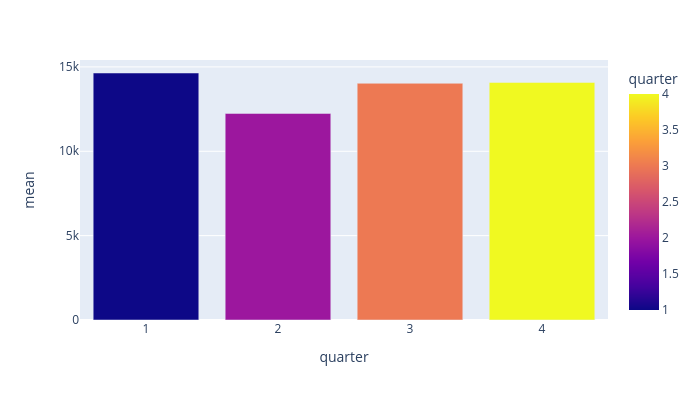

In [21]:
def plot_mean_by_col(col):
    bar_df = {"mean": []}
    bar_df[col] = []

    for value in list(dataset[col].unique()):
        bar_df[col].append(value)
        bar_df["mean"].append(dataset[(dataset[col] == value)]['Passengers In'].mean())

    fig = px.bar(bar_df, x=col, y='mean', color=col,
                labels={'Mean value per quarter'}, height=400)
    fig.show('png')

plot_mean_by_col('quarter')

## Correlação de ano em relação ao número de passageiros

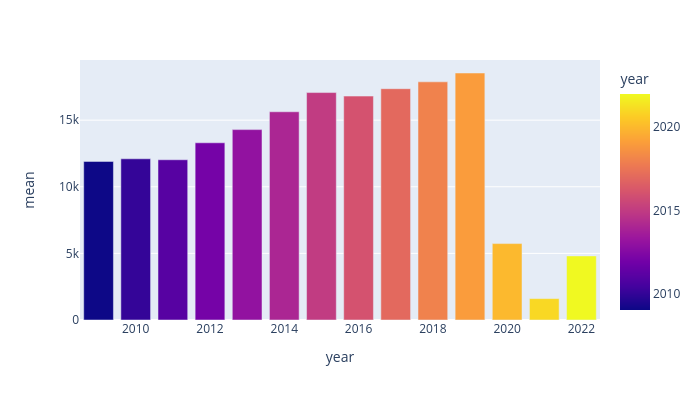

In [22]:
plot_mean_by_col('year')

Analisando-se o gráfico acima é possível notar a influencia clara da pandemia do `covid-19` em relação ao número de passageiros. Até o ano de 2019 era possível notar uma tendência de subida na média de passageiros, porém em 2020 ja foi possível notar a queda considerável do número de passageiros, o que pode nos indicar uma quebra no regime das séries temporais de passageiros de todos os continentes a partir da pandemia do `covid-19`.

## Agora vamos verificar a média de passageiros entrantes a partir de todos os continentes de origem

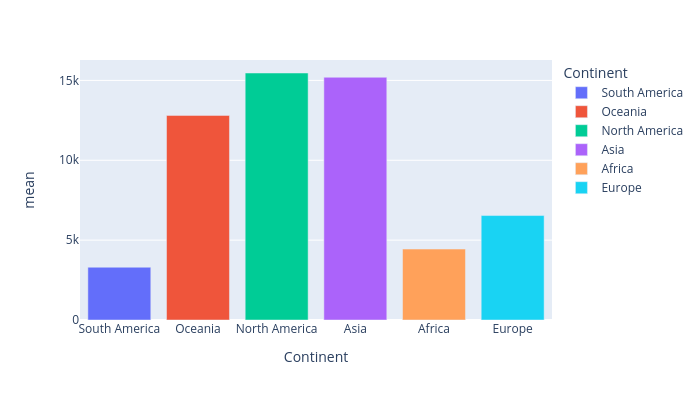

In [23]:
plot_mean_by_col('Continent')

A partir do gráfico acima podemos ver uma diferença clara entre os números passageiros entrantes tendo em vista o continente de origem, o que era de certa forma esperado, visto que a situação socioeconómica de cada continente é diferente.

## 4. Analisando a série temporal de um dos continentes <a name=serie></a>
Vamos agora selecionar uma série temporal e realizar a inspeção visual. Para essa primeira análise foi selecionado o continente da Ásia.

In [24]:
asia_series = dataset[(dataset['Continent'] == 'Asia')]

In [25]:
asia_series.head()

,Month,Scheduled Operator,Country to/from,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,Year,date,Continent,year,quarter
4,2009-01-01,Air China,China,12458.0,201.314,18.569,11163.0,142.408,2.93,2009,2009-01-01,Asia,2009,1
14,2009-01-01,AirAsia X,Malaysia,21143.0,106.524,0.000,17676.0,57.274,0.00,2009,2009-01-01,Asia,2009,1
16,2009-01-01,Airnorth,Indonesia,397.0,0.000,0.000,325.0,0.000,0.00,2009,2009-01-01,Asia,2009,1
17,2009-01-01,Asiana Airlines,Korea,8996.0,164.319,7.170,7684.0,74.990,0.00,2009,2009-01-01,Asia,2009,1
18,2009-01-01,British Airways,Singapore,2602.0,114.784,0.000,2064.0,156.193,0.00,2009,2009-01-01,Asia,2009,1


Ao olhar a tabela gerada selecionando a Asia como continente, é possível notar um problema, a cada passo de tempo temos multiplos valores de número de passageiros, os quais são fornecidos por cada agencia de vôo. Assim é necessário primeiramente agrupar os valores numéricos da tabela por data.

In [26]:
numeric_cols = ['Passengers In','Freight In','Mail In','Passengers Out','Freight Out','Mail Out']
asia_series = asia_series.groupby(asia_series.date.dt.date)[numeric_cols].sum()
asia_series = asia_series.reset_index()
asia_series['date'] = pd.to_datetime(asia_series['date'], format="%Y-%m-%d")
asia_series['quarter'] = asia_series['date'].dt.quarter
asia_series.head()

,date,Passengers In,Freight In,Mail In,Passengers Out,Freight Out,Mail Out,quarter
0,2009-01-01,811923.0,17704.257,1290.664,648098.0,21150.281,443.440,1
1,2009-02-01,639633.0,18032.926,998.258,492025.0,20802.984,354.804,1
2,2009-03-01,580486.0,22832.144,1083.058,576671.0,22594.186,416.246,1
3,2009-04-01,577752.0,20397.789,1110.408,599690.0,19859.029,369.837,2
4,2009-05-01,505056.0,21683.527,1237.992,573690.0,17563.889,387.354,2


Agora a cada dia temos valores numéricos para a nossa tabela.

Agora vamos realizar a visualização e análise da série temporal principal, a de passageiros.

## Comportamento da série de passageiros

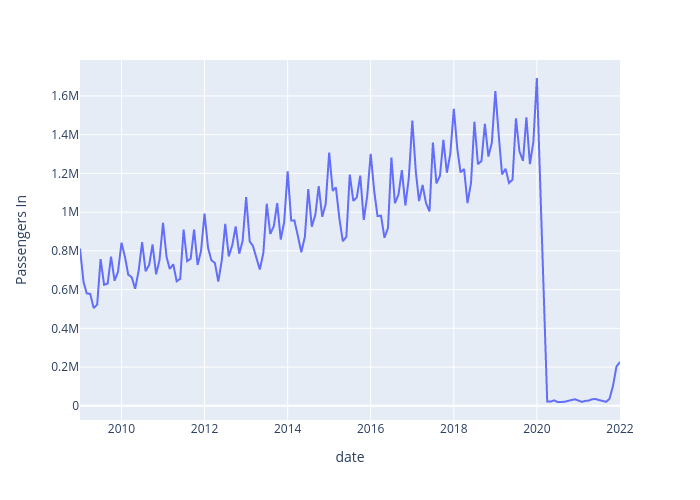

In [27]:

fig = px.line(asia_series, x='date', y='Passengers In')
fig.show('png')

Olhando o gráfico acima é possível notar a presença de picos anuais e dois pequenos picos que antecedem o anual. Agora vamos visualizar o dado novamente com visualizando o numero do trimestre a cada pico, para entender se os picos estão relacionados com o trimestre.

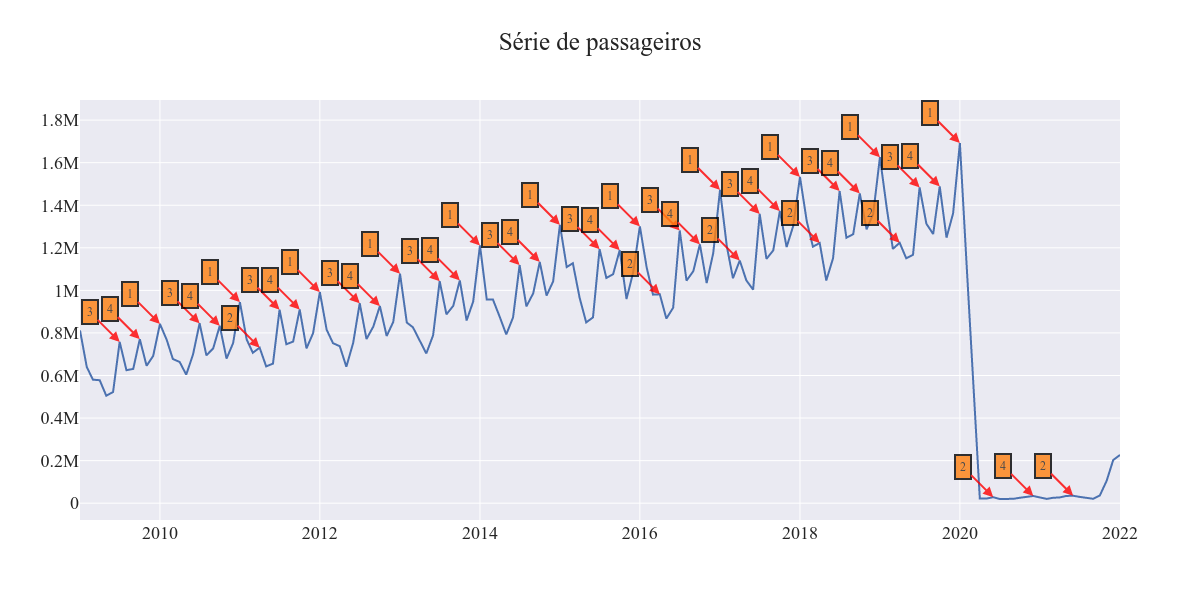

In [28]:
fig = go.Figure(data=go.Scatter(y=asia_series['Passengers In'], x=asia_series['date']))

all_peaks_indices = np.array([])
indices = find_peaks(asia_series['Passengers In'], distance = 3,)[0]

for idx in indices:
    xref = 'x'
    yref = 'y'
    fig.add_annotation(
            x=asia_series['date'][idx],
            y=asia_series['Passengers In'][idx],
            xref=xref,
            yref=yref,
            text=f"{asia_series['quarter'][idx]}",
            showarrow=True,
            font=dict(
                size=12,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Red",
            ax=-30,
            ay=-30,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Série de passageiros',

)
fig.show('png')

Assim é possível notar que o pico anual sempre acontece no primeiro trimestre, seguindo desse pico acontece os picos dos trimestres 3 e 4, e por ultimo o menor pico anual é sempre no segundo trimestre.

## Autocorrelação da série temporal e análise
Agora vamos visualizar a autocorrelação da série temporal e tentar identificar padrões sazonais.

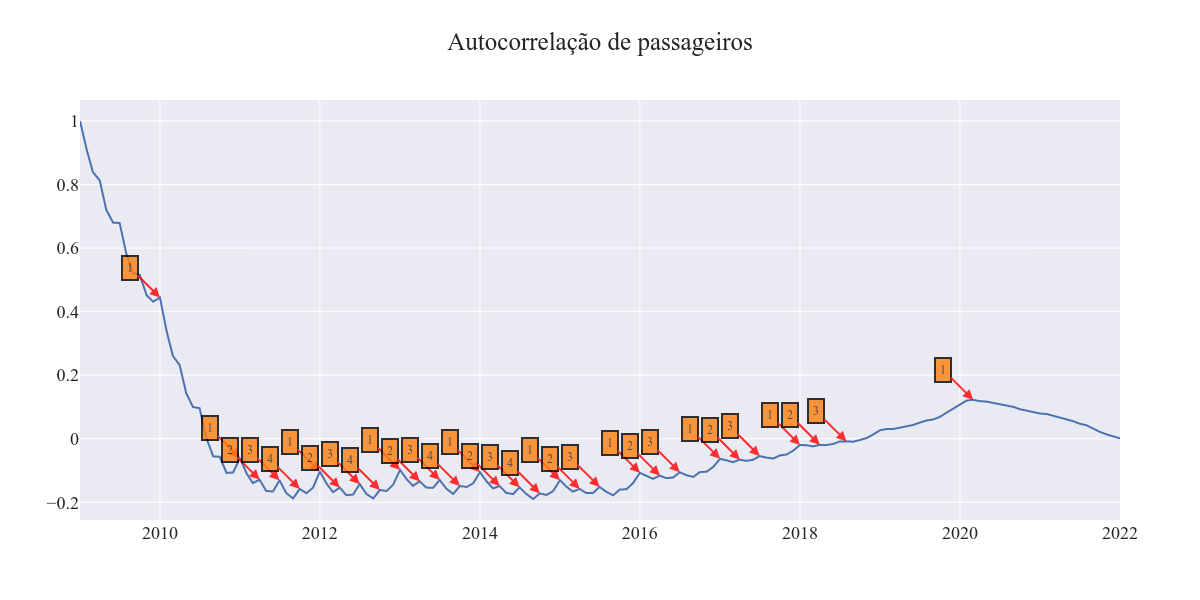

In [29]:
asia_series['auto_corr'] = statsmodels.tsa.stattools.acf(asia_series['Passengers In'].values, nlags = len(asia_series), fft=False)

fig = go.Figure(data=go.Scatter( x=asia_series['date'], y=asia_series['auto_corr']))
all_peaks_indices = np.array([])
indices = find_peaks(asia_series['auto_corr'], distance = 3,)[0]

for idx in indices:
    xref = 'x'
    yref = 'y'
    fig.add_annotation(
            x=asia_series['date'][idx],
            y=asia_series['auto_corr'][idx],
            xref=xref,
            yref=yref,
            text=f"{asia_series['quarter'][idx]}",
            showarrow=True,
            font=dict(
                size=12,
                ),
            align="center",
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor="Red",
            ax=-30,
            ay=-30,
            bordercolor="Black",
            borderwidth=2,
            borderpad=4,
            bgcolor="#ff7f0e",
            opacity=0.8
            )

fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    font=dict(
    family="Times new Roman",
    size=18),
    template='seaborn',
    title='Autocorrelação de passageiros',

)
fig.show('png')

A partir do gráfico de autocorrelação e da inspeção visual da série é possível afirmar que a série temporal de passageiros possui um padrão que se repete anualmente. Isso é possível de se afirmar ao observar que os picos de autocorrelação se repetem a cada ano, dessa forma a série temporal de passageiros possui um padrão anual.

De forma semelhante é possível identificar padrões sazonais a cada trimestre, visualizando os pequenos picos que antecedem os picos anuais de autocorrelação.

## Teste de estacionaridade no sentido amplo
Uma das análises mais importantes de dados de séries temporais é detectar se a série em questão é estacionária em sentido amplo ou não estacionária. Estacionaridade em sentido amplo de uma série temporal é uma característica que assegura que a série temporal não apresenta uma tendencia forte de descida ou subida e que esta série não apresenta sazonalidade. Utilizando-se dos dados de autocorrelação ja é um forte indicativo que a série temporal apresenta sazonalidade anual e somente utilizando essa informação é possível afirmar que a nossa série é não estacionária no sentido amplo. Porém podemos confirmar essa hipótese utilizando o teste de estacionaridade.

Muitos autores de artigos que utilizam machine learning para séries temporais defendem que usar esse tipo de modelo de aprendizado de máquina não exige necessariamente que os dados já estejam estacionários. No entanto, é importante saber se os dados são estacionários mesmo que o modelo selecionado seja baseado em ML, pois se o modelo não convergir bem isso pode ser uma causa e conhecer as propriedades da série também é muito valioso.

[1] Defina uma série temporal estacionária fraca se a função média $ E[x(t)] $ for independente de $ t $, se a função de autocoraviação $Cov (x(t+h), x(t))$ for independente de $ t $ para cada $h$ e se $E[x^2[n]]$ for finito para cada $n$.

Para realizar o teste de estacionaridade, a função média e a função de autocovariação foram aplicadas sobre janelas rolantes, desde seus dados amostrados. Assim, o tamanho da janela tem impacto sobre as interpretações das funções, a janela representa o intervalo em que a hipótese estacionária é testada.

Além desta definição, a biblioteca $ statsmodels $ possui o teste de raiz unitária Augmented Dickey-Fuller. O teste Augmented Dickey-Fuller pode ser usado para testar uma raiz unitária em um processo univariado na presença de correlação sazonal.

Referências
[1] Brockwell, Peter J. e Richard A. Davis. Introdução às séries temporais e previsão. Springer, 2016.

In [30]:
def stationary_test(entry,delta=200,ad=False,std=False):
    window_size=int(len(entry)/15)
    # Weak stationary test
    # Mean function
    mean_y = []
    mean_x = []

    s_moment_y = []
    std_y = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size)):
        # Roling window start and end
        n_start = i
        n_end = n_start + window_size
        # Mean, standard deviation and second moment calculation
        mean_y_i = np.mean(entry[n_start:n_end])
        s_moment_y_i = moment(entry[n_start:n_end],moment=2)
        std_y_i = np.std(entry[n_start:n_end])
        # Saving the results 
        mean_y.append(mean_y_i)
        mean_x.append(n_end)
        s_moment_y.append(s_moment_y_i)
        std_y.append(std_y_i)

    # Autocovariance function
    acov_y = []
    acov_x = []
    n_data = len(entry)
    for i in range(0, int(n_data - window_size - delta)):
        n_start = i
        n_end = n_start + window_size
        acov_y_i = np.cov(
            entry[n_start:n_end], entry[n_start+delta:n_end+delta]
        )[0][0]
        acov_y.append(acov_y_i)
        acov_x.append(n_end)
    if(ad):
        result = adfuller(entry)
        print("ADF Statistic: %f" % result[0])
        print("p-value: {0}".format(result[1]))
        print("Critical Values:")
        for key, value in result[4].items():
            print("\t%s: %.3f" % (key, value))
        # if the p-value < 0.05  and the adf statistic is less than
        # critical values the series is stationary or is time independent
    return [mean_x,mean_y],[acov_x,acov_y], s_moment_y, std_y

ADF Statistic: -1.986778
p-value: 0.2924002061474772
Critical Values:
	1%: -3.477
	5%: -2.882
	10%: -2.578


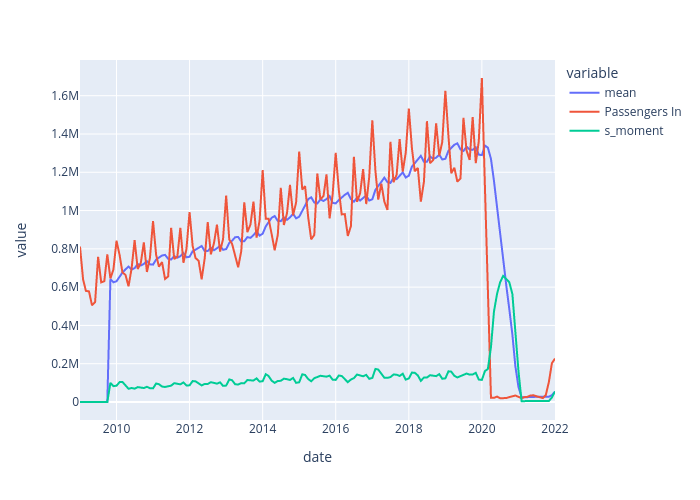

In [31]:
# Weak stationary test
sales_train = asia_series['Passengers In'].to_numpy()

mean, cov, s_moment, std = stationary_test(sales_train, delta=20,ad=True)
mean_value = np.zeros(len(sales_train))
mean_value[mean[0][0]:] = mean[1]

cov_value = np.zeros(len(sales_train))
cov_value[cov[0][0]:len(cov[1])+cov[0][0]] = cov[1]

std_value = np.zeros(len(sales_train))
std_value[mean[0][0]:] = std

s_moment_value = np.zeros(len(sales_train))
s_moment_value[mean[0][0]:] = s_moment

asia_series['mean'] = mean_value
asia_series['cov'] = cov_value
asia_series['s_moment'] = std_value

fig = px.line(asia_series, x='date', y=['mean', 'Passengers In', 's_moment'])
fig.show('png')

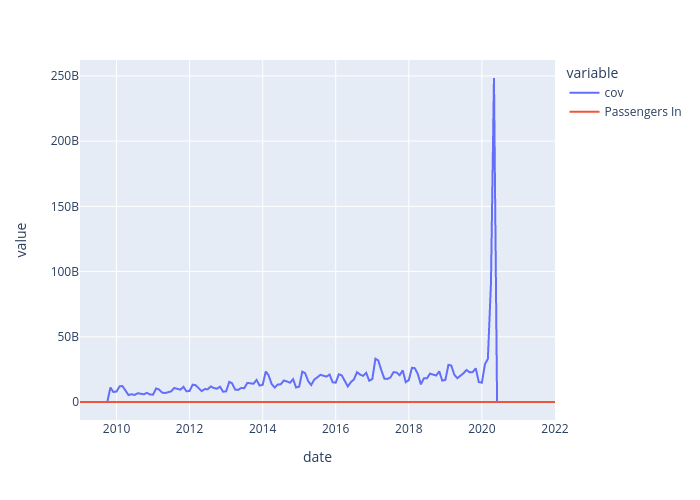

In [32]:

fig = px.line(asia_series, x='date', y=['cov', 'Passengers In'])
fig.show('png')

## Analisando os resultados do teste
A hipótese de teste da função média falhou, isto pode ser observado verificando a função seguindo a tendência e a sazonalidade das séries de passageiros entrantes, a função de covariação apresenta um comportamento de crescimento explosivo. A função de segundo momento não mostra uma tendência para o infinito com qualquer $n$, passando dessa forma esta condição.

Analisando os gráficos de funções é correto inferir que esta série de passageiros entrantes não é estacionária, isto também pode ser observado no gráfico de autocorrelação, que mostra um comportamento de decadência lenta.o gráfico de autocorrelação mostra também um comportamento periódico, que representa um comportamento periódico na série temporal.

Além dos testes de estatística em janela, o teste de Dickey-Fuller implementado pode ser feito para verificar se a série de passageiros entrantes é estacionária ou não. Este teste verifica se a série tem uma raiz unitária e, ao fazê-lo, pode fazer a suposição de quanto a série é definida pela sua tendência.

Existem 2 Hipóteses:

Hipótese Nula (H0): Se não for rejeitada, sugere que a série tem uma raiz unitária, o que significa que é não-estacionária. Tem alguma estrutura dependente do tempo.

Hipótese alternativa (H1): A hipótese nula é rejeitada; sugere que a série não tem uma raiz unitária, o que significa que é estacionária. Não tem uma estrutura dependente do tempo.

Interpretamos este resultado utilizando o valor p do teste. Um valor p abaixo de um limiar (como 5% ou 1%) sugere que rejeitamos a hipótese nula (estacionária), caso contrário, um valor p acima do limiar sugere que não rejeitamos a hipótese nula (não estacionária).

p-valor > 0,05: Não rejeitar a hipótese nula (H0), os dados têm uma raiz unitária e são não-estacionários.
p-valor <= 0,05: Rejeitar a hipótese nula (H0), os dados não têm uma raiz unitária e são estacionários.

Uma vez que o valor p do valor do teste aplicado à série é superior a 0,05, a hipótese nula é rejeitada, assim a série é não estacionária

## Correlação de número de passageiros com as outras variáveis
Agora vamos analisar a correlação de número de passageiros com as outras variáveis para verificar se estas serão boas features para os nossos modelos

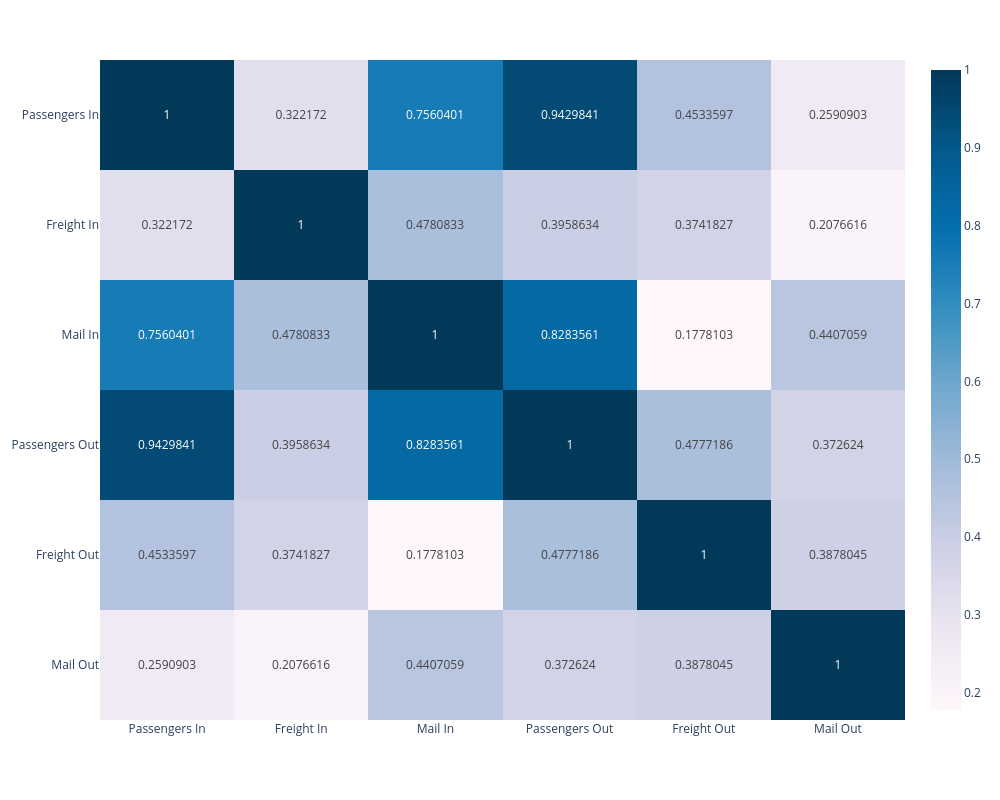

In [33]:
fig = px.imshow(asia_series[numeric_cols].corr(), text_auto=True ,color_continuous_scale='PuBu', width=1000, height=800, aspect="auto")
fig.show('png')

 A partir do gráfico correlação cruzada é possível concluir que as variáveis de 'Pasengers Out' e 'Mail in' tem uma correlação boa em relação ao numero de passageiros 'Passengers in', porém também é possível observar que 'Pasengers Out' e 'Mail in' tem uma correlação grande entre si, o que pode significar colinearidade.

## Gerando as séries de valores numéricos para todos os continentes de origem
Agora vamos gerar as séries de todos os continentes de origem e verificar a relação dessas séries entre si, caso haja uma relação relevante por exemplo do número de passageiros entrantes como origem da Ásia e como origem da América do norte, isso pode ser de grande valia para o nosso modelo de previsão.

In [34]:
def get_all_continent_sets(dataset, numeric_cols, rename=False):
    datasets = []
    continents = list(dataset['Continent'].unique())
    for continent in continents:
        dataset_i = dataset[(dataset['Continent'] == continent)]
        dataset_i = dataset_i.groupby(dataset_i.date.dt.date)[numeric_cols].sum()
        dataset_i = dataset_i.reset_index()
        dataset_i['date'] = pd.to_datetime(dataset_i['date'], format="%Y-%m-%d")
        dataset_i['quarter'] = dataset_i['date'].dt.quarter

        if rename:
            # Rename numeric cols
            rename_df = {}
            for col in numeric_cols:
                rename_df[col] = f'{col}_{continent}'

            dataset_i.rename(columns=rename_df, inplace = True)
            dataset_i.head()

        datasets.append(dataset_i)


    return datasets, continents


In [35]:
continent_sets, continent_names = get_all_continent_sets(dataset, numeric_cols)

## Verificando continuidade das no campo de data para cada continente

In [36]:
start_date, end_date = dataset['date'].to_list()[0], dataset['date'].to_list()[-1]
continuous_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

print(f'Quantidade de meses no dataset: {len(dataset["date"].unique())}')

for continent_set, name in zip(continent_sets, continent_names):
    print(f'Continente {name}| Número de meses: {len(continent_set["date"].unique())}')

Quantidade de meses no dataset: 157
Continente South America| Número de meses: 150
Continente Oceania| Número de meses: 157
Continente North America| Número de meses: 157
Continente Asia| Número de meses: 157
Continente Africa| Número de meses: 139
Continente Europe| Número de meses: 142


In [37]:
print(f'Numero correto de meses no periodo {len(continuous_dates)}')

Numero correto de meses no periodo 157


Como é possível ver, apenas 3 continentes tem a quantidade correta de data, que é 157 meses, dessa forma é preciso tratar esses valores como faltantes antes de seguir adiante com as análises.

In [38]:
for i, continent_set in enumerate(continent_sets):
    continent_set = continent_set.set_index('date')
    continent_set = continent_set.reindex(dataset['date'].unique(), method='bfill')
    continent_set = continent_set.fillna(method='ffill')
    continent_sets[i] = continent_set.reset_index()

In [39]:
print(f'Quantidade de meses no dataset: {len(dataset["date"].unique())}')
for continent_set, name in zip(continent_sets, continent_names):
    print(f'Continente {name}| Número de meses: {len(continent_set["date"].unique())}')

Quantidade de meses no dataset: 157
Continente South America| Número de meses: 157
Continente Oceania| Número de meses: 157
Continente North America| Número de meses: 157
Continente Asia| Número de meses: 157
Continente Africa| Número de meses: 157
Continente Europe| Número de meses: 157


In [40]:
for continent_set, name in zip(continent_sets, continent_names):
    print(f'Continent {name} | NaN values {continent_set.isnull().sum()}')

Continent South America | NaN values date              0
Passengers In     0
Freight In        0
Mail In           0
Passengers Out    0
Freight Out       0
Mail Out          0
quarter           0
dtype: int64
Continent Oceania | NaN values date              0
Passengers In     0
Freight In        0
Mail In           0
Passengers Out    0
Freight Out       0
Mail Out          0
quarter           0
dtype: int64
Continent North America | NaN values date              0
Passengers In     0
Freight In        0
Mail In           0
Passengers Out    0
Freight Out       0
Mail Out          0
quarter           0
dtype: int64
Continent Asia | NaN values date              0
Passengers In     0
Freight In        0
Mail In           0
Passengers Out    0
Freight Out       0
Mail Out          0
quarter           0
dtype: int64
Continent Africa | NaN values date              0
Passengers In     0
Freight In        0
Mail In           0
Passengers Out    0
Freight Out       0
Mail Out          0
quart

## Agora vamos visualizar a relação da coluna de passageiros entrantes tem relação a amostras de 6 meses anteriores dos valores numericos
Esse tipo de análise é importante para visualizar se esses dados serão de alguma valia para inserir em modelos que aceitam entradas exógenas como o ARIMAX, e visto que não teremos acesso a essas covariantes numéricas no futuro teremos que associar o valor de passageiros entrantes em relação aos 6 meses anteriores dos valores numéricos, que estarão a nossa disposição.

In [41]:
def generate_lag_set(entry_set, numeric_cols):
    lag_set = entry_set[::]
    lag_order = 6
    cols = numeric_cols[1:]
    for col in cols:
        lag_set[col] = lag_set[col].shift(lag_order)

    lag_set[f'Passengers in lag'] = lag_set['Passengers In'].shift(lag_order)
    lag_set = lag_set.dropna()
    lag_set.head()
    numeric_cols.append('quarter')
    numeric_cols.append('Passengers in lag')
    return lag_set, numeric_cols


In [42]:
numeric_cols

['Passengers In',
 'Freight In',
 'Mail In',
 'Passengers Out',
 'Freight Out',
 'Mail Out']

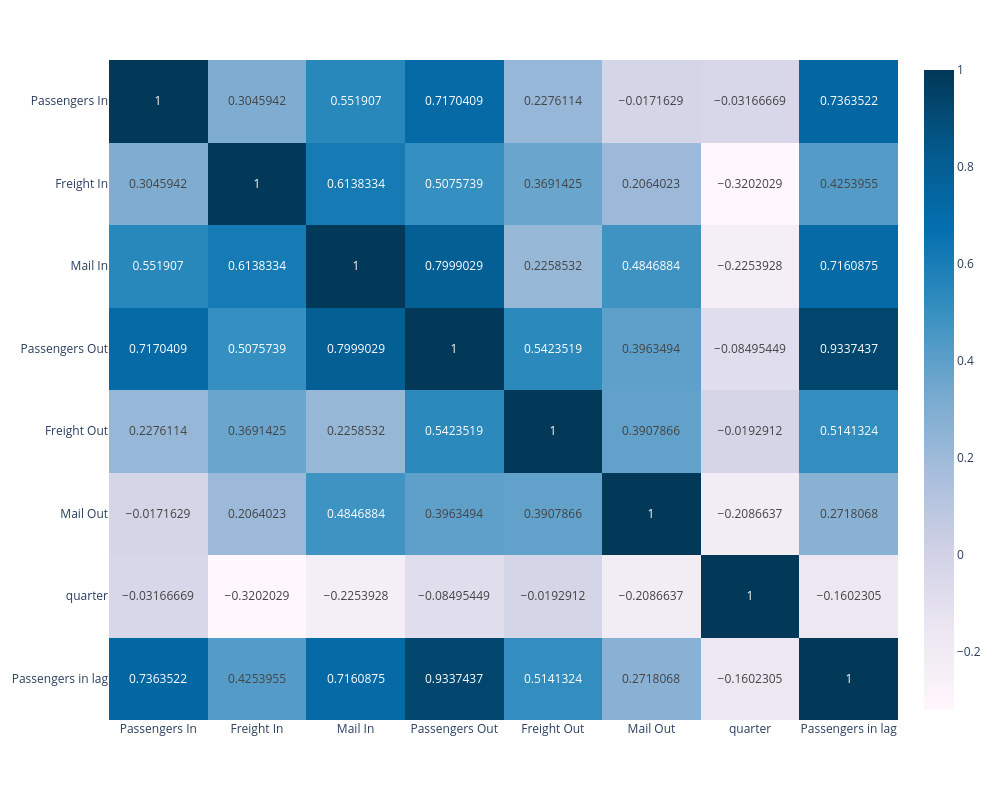

In [43]:
lag_asia_set, new_numeric_cols = generate_lag_set(asia_series, numeric_cols)
fig = px.imshow(lag_asia_set[new_numeric_cols].corr(), text_auto=True ,color_continuous_scale='PuBu', width=1000, height=800, aspect="auto")
fig.show('png')

Olhando para o gráfico de correlação acima é possível ver duas variáveis que ainda podem trazer alguma valia para o nosso modelo, as quais são `mail in` e `passengers out`. Agora vamos partir para a modelagem e testar os modelos treinando somente com a série temporal de passageiros e com as séries temporais exogenas com o atraso de 6 meses, para evitar o problema de "olhar para o futuro" durante o treinamento.

## 5. Modelagem <a name=modelagem></a>

Para modelar a predição de 6 meses a frente da série temporal de passageiros entrantes na Austrália a partir de todos os continentes vamos utilizar quatro modelos, sendo estes:

- `ARIMA`: Modelo amplamente utilizado na literatura para vários casos, altamente performático e bastante utilizado no mercado.
- `Light GBM`: Modelo baseado em árvores de decisão e gradient boosting, é dito estar no estado da arte na modelagem de dados tabulares para vários tipos de tarefas e altamente performático.

- `Prophet`: Modelo de previsão de séries temporais desenvolvido pelo Facebook, amplamente utilizado e performático.
- `Regressão linear`: Modelo baseado em regressão linear de covariantes em relação a série temporal desejada.

## ARIMA

O modelo ARIMA tem 3 componentes, o componente autoregressivo (AR), o componente de médias móveis (MA) e o componente Integrativo (I).

Primeiramente vamos modelar o ARIMA utilizando somente a série endogena (passageiros entrantes) e depois vamos utilizar as outras colunas numéricas com um atraso de 6 meses e verificar qual foi a melhor abordagem.

In [44]:
test_sz = 6
dummy_set = asia_series[:200]
dataset_train, dataset_test = dummy_set.iloc[:-test_sz], dummy_set.iloc[-test_sz:]
lag_set_train, lag_set_test = lag_asia_set.iloc[:-test_sz], lag_asia_set.iloc[-test_sz:]
exog_cols = new_numeric_cols[1:]

In [45]:
def plot_forecast(series_train, series_test, forecast, y_col='Passengers In', continent='', forecast_int=None):

    mae = mean_absolute_error(series_test[y_col], forecast)
    mape = mean_absolute_percentage_error(series_test[y_col], forecast)

    fig = make_subplots(rows=2, cols=1,
                    subplot_titles=[f'All time series', 'Prediction and ground truth'],
                    x_title='Input time steps',
                    y_title='Output time steps')
    fig.add_trace(go.Scatter( x=series_train['date'], y=series_train[y_col], name='Train data'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series_test['date'], y=series_test[y_col],  name='True values'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series_test['date'], y=forecast,  name='forecast'), row=1, col=1)
    fig.add_trace(go.Scatter(x=series_test['date'], y=series_test[y_col],  name='True values'), row=2, col=1)
    fig.add_trace(go.Scatter(x=series_test['date'], y=forecast,  name='forecast'), row=2, col=1)

    fig.update_layout(
        autosize=False,
        width=1200,
        height=600,
        font=dict(
        family="Times new Roman",
        size=18),
        template='seaborn',
        title=f"Forecast continent: {continent} | MAE: {mae:.2f} | MAPE: {mape:.3f}",
    )
    fig.show('png')

In [46]:
def arima_fit_pred(dataset_train, dataset_test, continent, exog=None, exog_cols=None, plot=True):
    forecaster = AutoARIMA(sp=12, suppress_warnings=True)
    dataset_train.index = dataset_train.index.astype(int)
    if exog:
        X=dataset_train[exog_cols]
    else:
        X=None
    forecaster.fit(dataset_train['Passengers In'], X=X)
    forecaster.summary()
    test_sz = len(dataset_test)
    fh = np.arange(test_sz) + 1

    if exog:
        X=dataset_test[exog_cols]

    forecast, forecast_int = forecaster.predict(fh=fh, return_pred_int=True, alpha=0.05, X=X)
    if plot:
        plot_forecast(dataset_train, dataset_test, forecast, continent=continent)

    return forecaster, forecast

### Fit e predição utilizando somente a série endogena

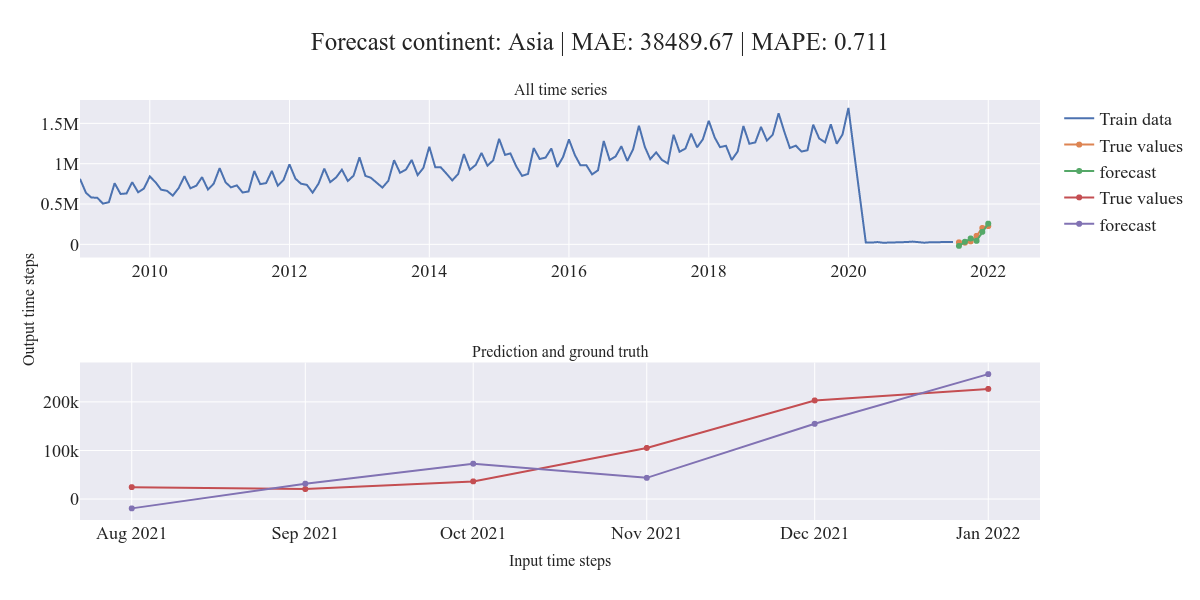

In [47]:
arima_model, arima_pred = arima_fit_pred(dataset_train, dataset_test, 'Asia')


### Fit e predição utilizando covariantes de 6 meses atrás e a série de passageiros entrantes

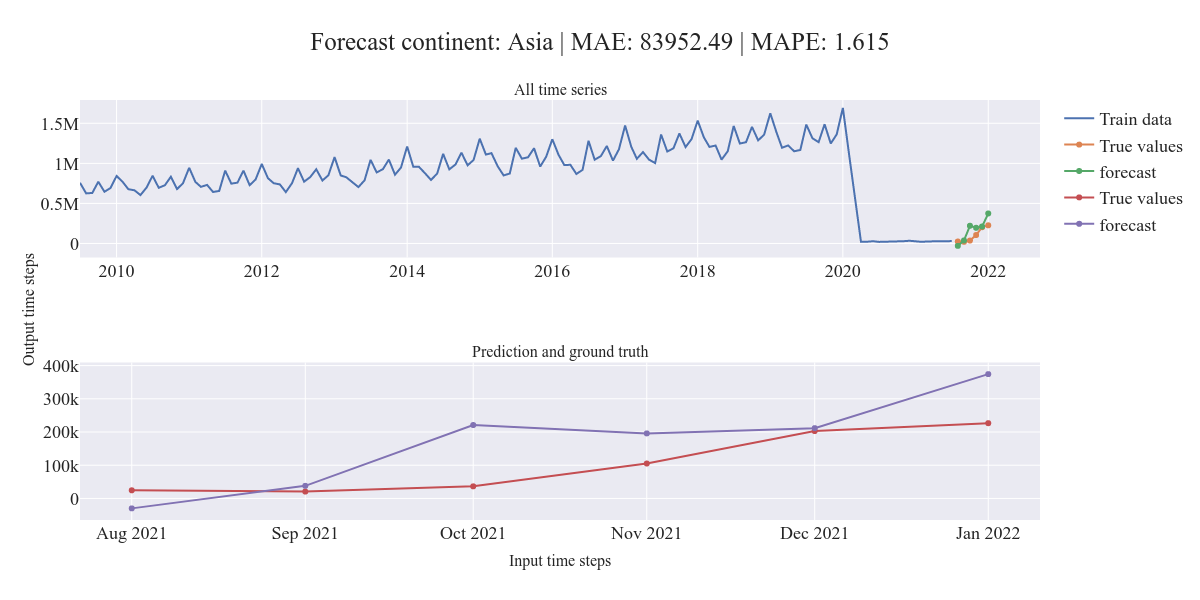

In [48]:
arima_model, arima_pred  = arima_fit_pred(lag_set_train, lag_set_test,'Asia', exog=True, exog_cols=exog_cols)

Como é possível ver nos resultados finais, as métricas de erro foram maiores ao se utilizar covariantes juntamente com o ARIMA. Dessa forma, o modelo ARIMA sem covariantes foi melhor a primeira vista, porém vamos realizar o teste para todos os continentes mais adiante e verificar se isso persiste.

## Light GBM

Semelhante ao ARIMA vamos testar o modelo utilizando somente a série de passageiros entrantes e depois com as outras covariantes. Para isso vamos utilizar uma busca de parâmetros utilizando o método de grid search, e utilizando o `sktime` nós iremos remover os componentes de tendência e sazonalidade.

In [49]:
def create_forecaster():

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster

def grid_search_forecaster(train, test, forecaster, param_grid, exog=None, exog_cols=None, y_col='Passengers In'):

    # Grid search on window_length
    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    if exog:
        X = train[exog_cols]
    else:
        X = None
    gscv.fit(train[y_col], X=X, fh=len(test))
    print(f"best params: {gscv.best_params_}")

    # forecasting
    fh=np.arange(len(test))+1
    if exog:
        X = test[exog_cols]
    else:
        X = None
    y_pred = gscv.predict(fh=fh, X=X)

    return gscv, y_pred


def create_forecaster_w_desesonalizer(sp=12, degree=1):

    # creating forecaster with LightGBM
    regressor = lgb.LGBMRegressor(learning_rate=0.2, n_estimators=100)
    forecaster = TransformedTargetForecaster(
        [
            ("deseasonalize", Deseasonalizer(model="multiplicative", sp=sp)),
            ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=degree))),
            (
                "forecast",
                make_reduction(regressor, window_length=12, strategy="recursive"),
            ),
        ]
    )

    return forecaster

def lgbm_fit_pred(train_set, test_set, continent ,y_col='Passengers In',exog=None, exog_cols=None, plot=True):

    forecaster = create_forecaster_w_desesonalizer()
    param_grid = {"forecast__window_length": [6, 24, 36], 'forecast__estimator__learning_rate': [0.1,  0.16, 0.2 ]}

    gscv, forecast = grid_search_forecaster(train_set, test_set, forecaster,param_grid, exog=exog, exog_cols=exog_cols, y_col=y_col)
    if plot:
        plot_forecast(train_set, test_set, forecast, continent=continent)

    return gscv, forecast


## Fit somente com a série de passageiros

best params: {'forecast__estimator__learning_rate': 0.16, 'forecast__window_length': 36}


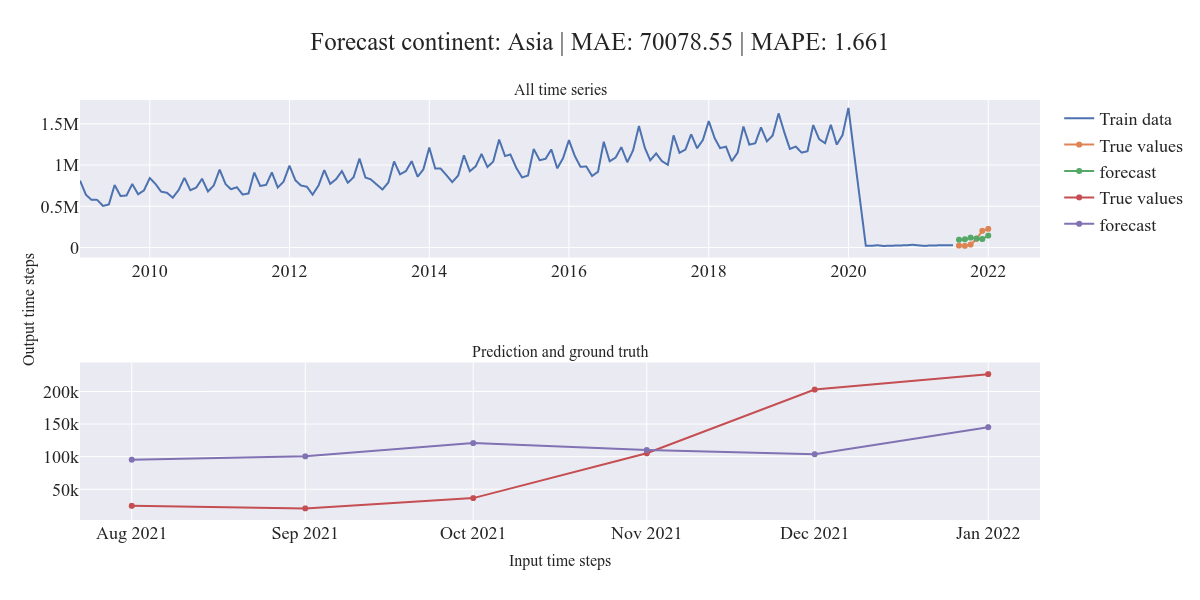

In [50]:
light_gbm_model, light_gbm_pred = lgbm_fit_pred(dataset_train, dataset_test, 'Asia')

## Fit com covariantes

best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 36}


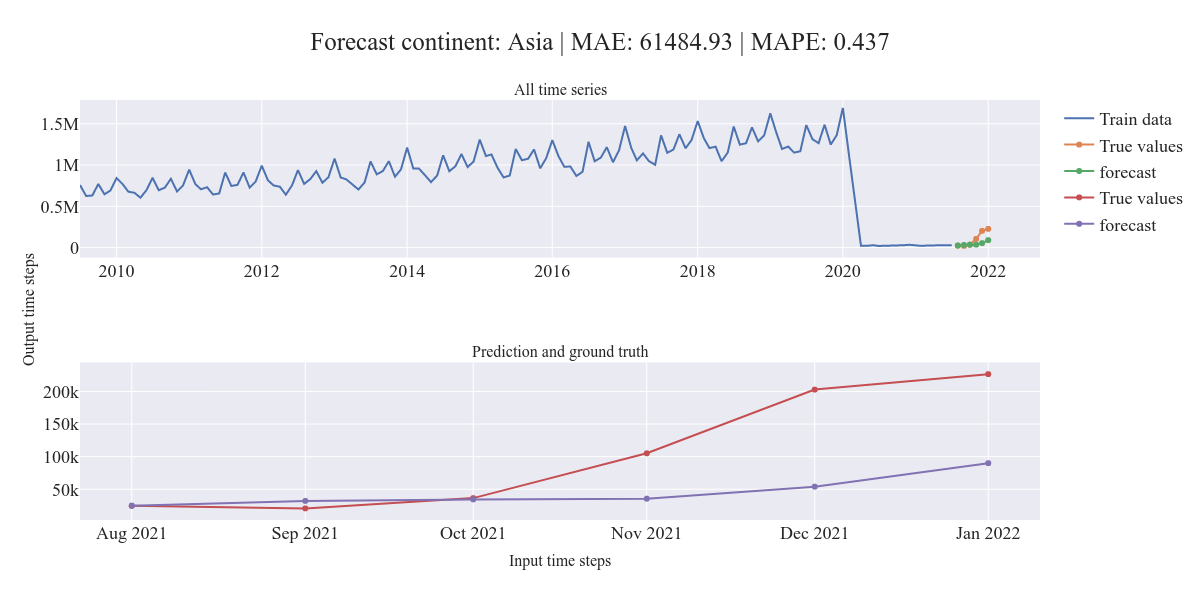

In [51]:
light_gbm_model, light_gbm_pred = lgbm_fit_pred(lag_set_train, lag_set_test,'Asia',exog=True, exog_cols=exog_cols)

Diferentemente do modelo ARIMA, o uso de covariantes foi benéfico no LGBM, porém ainda é necessário testar com a série dos outros continentes

## Prophet


O prophet diferentemente dos modelos anteriores não possibilita a entrada de covariantes, dessa forma vamos testa-lo utilizando somente a série de passageiros entrantes

In [59]:
def prophet_fit_pred(dataset_train, dataset_test , continent, plot=True ):
    al_train_pp = dataset_train[['date', 'Passengers In']]
    al_train_pp.head()

    # Prophet requires specific column names: ds and y
    al_train_pp.columns = ["ds", "y"]

    # turning on only yearly seasonality as this is monthly data.
    # As the seasonality effects varies across years, we need multiplicative seasonality mode
    m = Prophet(
        seasonality_mode="multiplicative",
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=0.001,
        seasonality_prior_scale=10,
        # changepoints=['2020-04-01']
    ).add_seasonality(name= 'monthly', period=30.5, fourier_order=12)
    m.fit(al_train_pp)

    future = m.make_future_dataframe(periods=test_sz, freq="M")
    forecast = m.predict(future)
    forecast = forecast.iloc[-test_sz:]
    forecast.rename(columns={"yhat_lower": "lower", "yhat_upper": "upper"}, inplace=True)

    if plot:
        plot_forecast(
            dataset_train, dataset_test, forecast['yhat'], continent=continent)

    return m, forecast['yhat']

Initial log joint probability = -13.1139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.1139             0       157.709       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -143.538
Iteration  1. Log joint probability =    3.58293. Improved by 147.121.
Iteration  2. Log joint probability =    55.2095. Improved by 51.6265.
Iteration  3. Log joint probability =     123.48. Improved by 68.2703.
Iteration  4. Log joint probability =    153.001. Improved by 29.5209.
Iteration  5. Log joint probability =     200.08. Improved by 47.0796.
Iteration  6. Log joint probability =      212.4. Improved by 12.3196.
Iteration  7. Log joint probability =    224.265. Improved by 11.8654.
Iteration  8. Log joint probability =    224.625. Improved by 0.360229.
Iteration  9. Log joint probability =    224.799

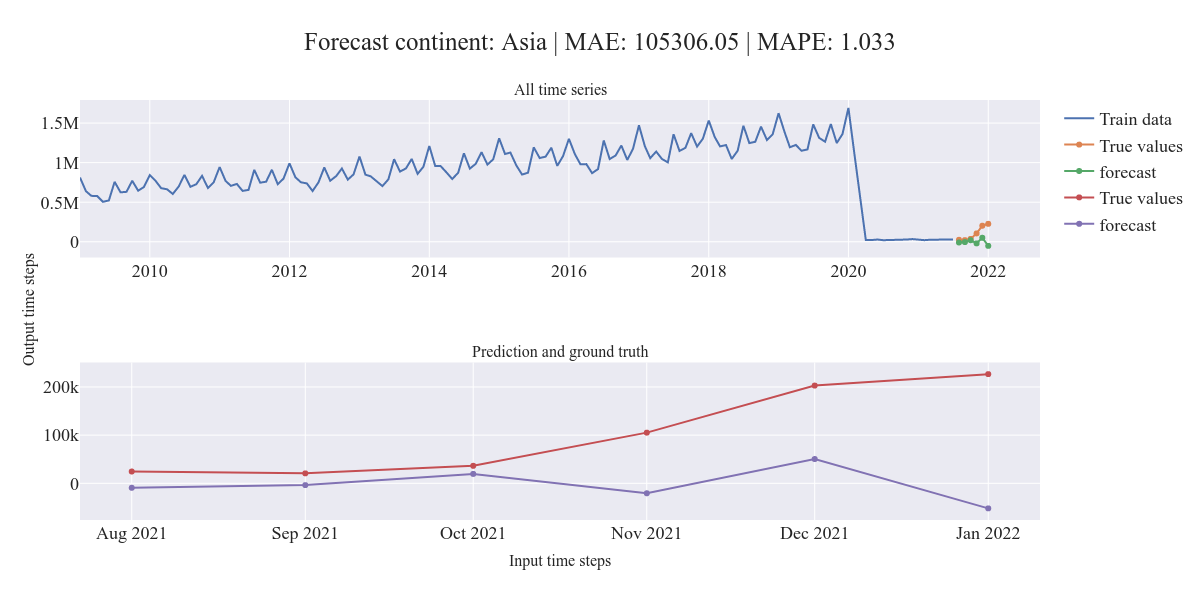

In [60]:
prophet_model, prophet_pred = prophet_fit_pred(dataset_train, dataset_test, 'Asia')

## Regressão linear simples

In [61]:
def linear_fit_pred(dataset_train, dataset_test, continent, exog=True ,exog_cols=exog_cols, plot=True):
    lr = LinearRegression()
    lr.fit(dataset_train[exog_cols], dataset_train['Passengers In'])
    y_pred_lr = pd.Series(lr.predict(X=dataset_test[exog_cols]),index=dataset_test.index)

    if plot:
        plot_forecast(
            dataset_train, dataset_test, y_pred_lr, continent=continent)

    return lr, y_pred_lr

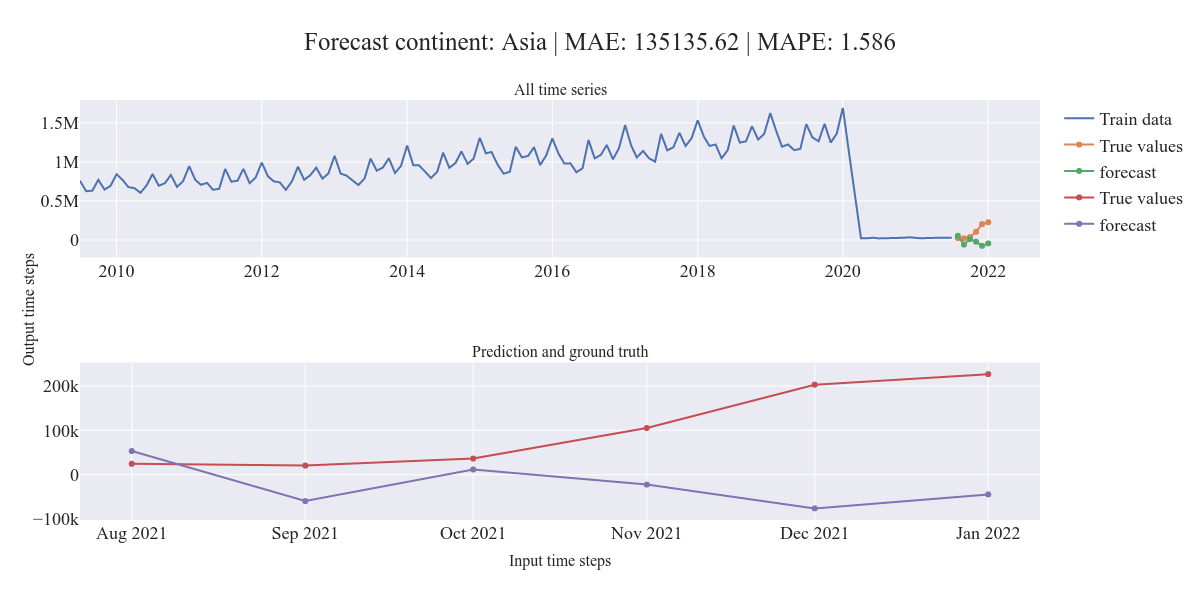

In [62]:
lr_model, lr_pred = linear_fit_pred(lag_set_train, lag_set_test, 'Asia', exog_cols)

## Realizando a previsão para todos os continentes


In [63]:
numeric_cols = list(dataset.columns[3:-5])
continent_sets, continent_names = get_all_continent_sets(dataset, numeric_cols, rename=False)

In [64]:
def fit_pred_all_continents(continents_dfs, continent_names, numeric_cols, y_col='Passengers In', test_sz=6):
    endog_models_df = {'Model': ['ARIMA', 'LGBM', 'Prophet'],
                       'Func': [arima_fit_pred, lgbm_fit_pred, prophet_fit_pred]}
    exog_models_df = {'Model': ['ARIMA', 'LGBM', 'LR'],
                       'Func': [arima_fit_pred, lgbm_fit_pred, linear_fit_pred]}

    result_df = {'Model': [], 'Continent': [],
                 'Exog': [],
                 'MAE': [],
                 'MAPE': [],
                 "R2": [],
                 'pred': [],
                 'y_true': [],
                 'date': [],
                 'forecaster': []}

    for continent_set, continent in zip(continents_dfs, continent_names):
        train_set, test_set = continent_set.iloc[:-test_sz], continent_set.iloc[-test_sz:]
        y_true = test_set[y_col]

        # Fit the models without any covariant
        for model, fit_func in zip(endog_models_df['Model'],  endog_models_df['Func']):
            result_df['Model'].append(model)
            forecaster, pred =  fit_func(train_set, test_set, continent, plot=False)

            #Setting negative predictions to zero
            y_pred = np.array([i  if i> 0 else 0 for i in pred ])

            result_df['Continent'].append(continent)
            result_df['Exog'].append(False)
            result_df['MAE'].append(mean_absolute_error(y_true, pred))
            result_df['MAPE'].append(mean_absolute_percentage_error(y_true, pred))
            result_df['R2'].append(r2_score(y_true, pred))
            result_df['pred'].append(y_pred)
            result_df['y_true'].append(y_true)
            result_df['date'].append(test_set['date'])
            result_df['forecaster'].append(forecaster)


    for continent_set, continent in zip(continents_dfs, continent_names):
        numeric_cols_i = numeric_cols[::]
        lag_continent_set, exog_cols = generate_lag_set(continent_set, numeric_cols_i)
        exog_cols = exog_cols[1:]
        train_set, test_set = lag_continent_set.iloc[:-test_sz], lag_continent_set.iloc[-test_sz:]
        y_true = test_set[y_col]

        # Fit the models without any covariant
        for model, fit_func in zip(exog_models_df['Model'],  exog_models_df['Func']):
            result_df['Model'].append(model)
            forecaster, pred =  fit_func(train_set, test_set, continent, plot=False, exog=True, exog_cols=exog_cols)
            # Setting negative predictions to zero
            y_pred = np.array([i  if i> 0 else 0 for i in pred ])
            result_df['Continent'].append(continent)
            result_df['Exog'].append(True)
            result_df['MAE'].append(mean_absolute_error(y_true, pred))
            result_df['MAPE'].append(mean_absolute_percentage_error(y_true, pred))
            result_df['R2'].append(r2_score(y_true, pred))
            result_df['pred'].append(y_pred)
            result_df['y_true'].append(y_true)
            result_df['date'].append(test_set['date'])
            result_df['forecaster'].append(forecaster)






    return result_df

In [65]:
numeric_cols_clone = numeric_cols[::]
result_df = fit_pred_all_continents(continent_sets, continent_names, numeric_cols_clone)

best params: {'forecast__estimator__learning_rate': 0.2, 'forecast__window_length': 36}
Initial log joint probability = -11.6911
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -11.6911             0       151.184       1e-12       0.001       17   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -135.683
Iteration  1. Log joint probability =    28.1393. Improved by 163.822.
Iteration  2. Log joint probability =      45.99. Improved by 17.8507.
Iteration  3. Log joint probability =    64.7238. Improved by 18.7338.
Iteration  4. Log joint probability =    93.5644. Improved by 28.8406.
Iteration  5. Log joint probability =    136.254. Improved by 42.6896.
Iteration  6. Log joint probability =    161.851. Improved by 25.5974.
Iteration  7. Log joint probability =    180.762. Improved by 18.9105.
Iteration  8. Log joint probabil

best params: {'forecast__estimator__learning_rate': 0.2, 'forecast__window_length': 24}
Initial log joint probability = -9.07443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -9.07443             0       154.293       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -139.499
Iteration  1. Log joint probability =    48.9467. Improved by 188.445.
Iteration  2. Log joint probability =    68.0474. Improved by 19.1007.
Iteration  3. Log joint probability =    128.895. Improved by 60.848.
Iteration  4. Log joint probability =    159.561. Improved by 30.6652.
Iteration  5. Log joint probability =    177.933. Improved by 18.3721.
Iteration  6. Log joint probability =    197.429. Improved by 19.4964.
Iteration  7. Log joint probability =    208.426. Improved by 10.9966.
Iteration  8. Log joint probabili

best params: {'forecast__estimator__learning_rate': 0.2, 'forecast__window_length': 36}
Initial log joint probability = -17.1048
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -17.1048             0       161.038       1e-12       0.001       17   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -147.529
Iteration  1. Log joint probability =    15.1275. Improved by 162.656.
Iteration  2. Log joint probability =     67.123. Improved by 51.9955.
Iteration  3. Log joint probability =    82.3174. Improved by 15.1944.
Iteration  4. Log joint probability =    84.6546. Improved by 2.3372.
Iteration  5. Log joint probability =    110.054. Improved by 25.3997.
Iteration  6. Log joint probability =    114.998. Improved by 4.9434.
Iteration  7. Log joint probability =    146.149. Improved by 31.151.
Iteration  8. Log joint probability

best params: {'forecast__estimator__learning_rate': 0.16, 'forecast__window_length': 36}
Initial log joint probability = -13.1139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -13.1139             0       157.709       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -143.538
Iteration  1. Log joint probability =    3.58293. Improved by 147.121.
Iteration  2. Log joint probability =    55.2095. Improved by 51.6265.
Iteration  3. Log joint probability =     123.48. Improved by 68.2703.
Iteration  4. Log joint probability =    153.001. Improved by 29.5209.
Iteration  5. Log joint probability =     200.08. Improved by 47.0796.
Iteration  6. Log joint probability =      212.4. Improved by 12.3196.
Iteration  7. Log joint probability =    224.265. Improved by 11.8654.
Iteration  8. Log joint probabi

best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 36}
Initial log joint probability = -3.56953
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -3.56953             0       136.961       1e-12       0.001       22   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -117.453
Iteration  1. Log joint probability =    135.523. Improved by 252.976.
Iteration  2. Log joint probability =     213.37. Improved by 77.8468.
Iteration  3. Log joint probability =    302.085. Improved by 88.7153.
Iteration  4. Log joint probability =    358.793. Improved by 56.7079.
Iteration  5. Log joint probability =    365.242. Improved by 6.44933.
Iteration  6. Log joint probability =    370.709. Improved by 5.46709.
Iteration  7. Log joint probability =    372.429. Improved by 1.71998.
Iteration  8. Log joint probabil

best params: {'forecast__estimator__learning_rate': 0.1, 'forecast__window_length': 6}
Initial log joint probability = -4.28066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -4.28066             0       137.687       1e-12       0.001       18   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -120.921
Iteration  1. Log joint probability =    56.1512. Improved by 177.072.
Iteration  2. Log joint probability =    164.402. Improved by 108.251.
Iteration  3. Log joint probability =    209.551. Improved by 45.1491.
Iteration  4. Log joint probability =    236.044. Improved by 26.4924.
Iteration  5. Log joint probability =    249.252. Improved by 13.2077.
Iteration  6. Log joint probability =    281.361. Improved by 32.1097.
Iteration  7. Log joint probability =    301.731. Improved by 20.3694.
Iteration  8. Log joint probabili

In [66]:
metric_df = pd.DataFrame(result_df)

In [67]:
def plot_pred_continent(result_df, continent):

    fig = go.Figure(data=go.Scatter(x=result_df['date'].to_list()[0], y=result_df['y_true'].to_list()[0], name=f'Valor real'))
    for model, exog, y_pred in zip(result_df['Model'], result_df['Exog'], result_df['pred'].to_list()):
        fig.add_trace(go.Scatter(x=result_df['date'].to_list()[0], y=y_pred, name=f'{model} exog : {exog}'))

    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
        font=dict(
        family="Times new Roman",
        size=18),
        template='seaborn',
        title=f"Predição No continente :{continent}",
    )
    fig.show('png')

def plot_pred_all_continents(result_df, continent_names):

    # Maps continents to each row in graph
    map_continent_row = {}
    map_continent_show = {}
    for i, continent in enumerate(continent_names):
        map_continent_row[continent] = i
        map_continent_show[continent] = False

    rows = len(continent_names)

    fig = make_subplots(rows=rows, cols=1,
                    subplot_titles=[f'Prediction Continent :{i}' for i in continent_names],
                    x_title='Data',
                    y_title='Número de Passageiros entrantes')

    for continent, model, exog, y_pred in zip(result_df['Continent'], result_df['Model'] , result_df['Exog'], result_df['pred']):
        row = map_continent_row[continent]
        fig.add_trace(go.Scatter(x=result_df['date'].to_list()[0], y=y_pred, name=f'{model} exog : {exog}'), row=row+1, col=1)


    for continent, y_true in zip(result_df['Continent'], result_df['y_true']):
        if not map_continent_show[continent]:
            row = map_continent_row[continent]
            fig.add_trace(go.Scatter(x=result_df['date'].to_list()[0], y=y_true, name=f'Valor real {continent}'), row=row+1, col=1)
            map_continent_show[continent] = True

    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,
        font=dict(
        family="Times new Roman",
        size=18),
        template='seaborn',
        title=f"Predição em todos os continentes",
    )
    fig.show('png')

## Visualizando as predições por Continente
Agora vamos visualizar as predições de cada modelo para cada continente e verificar o comportamento das predições.

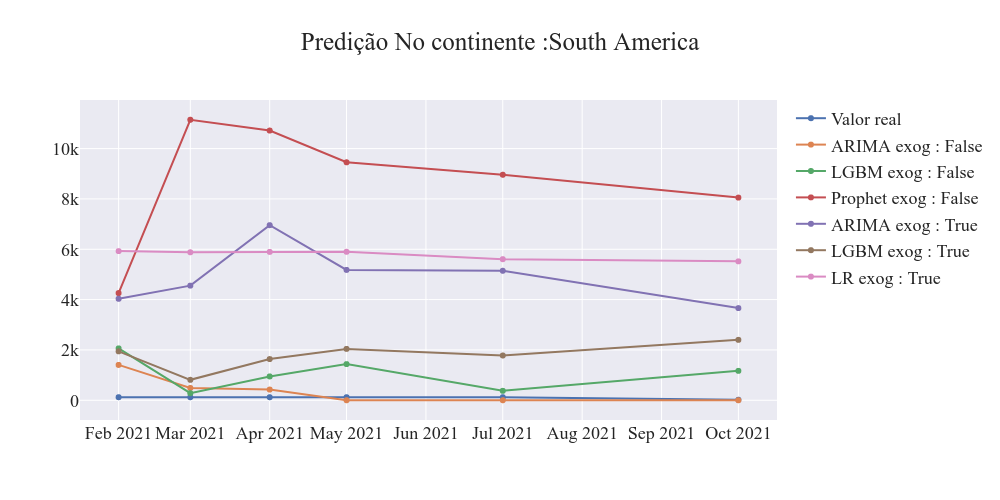

In [68]:
plot_pred_continent(metric_df.loc[metric_df['Continent'] == 'South America'], 'South America')

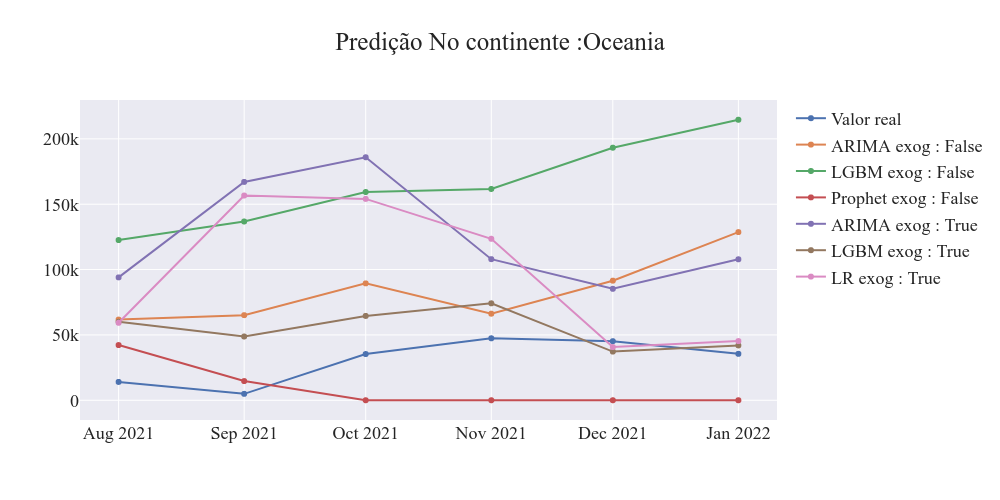

In [69]:
plot_pred_continent(metric_df.loc[metric_df['Continent'] == 'Oceania'], 'Oceania')

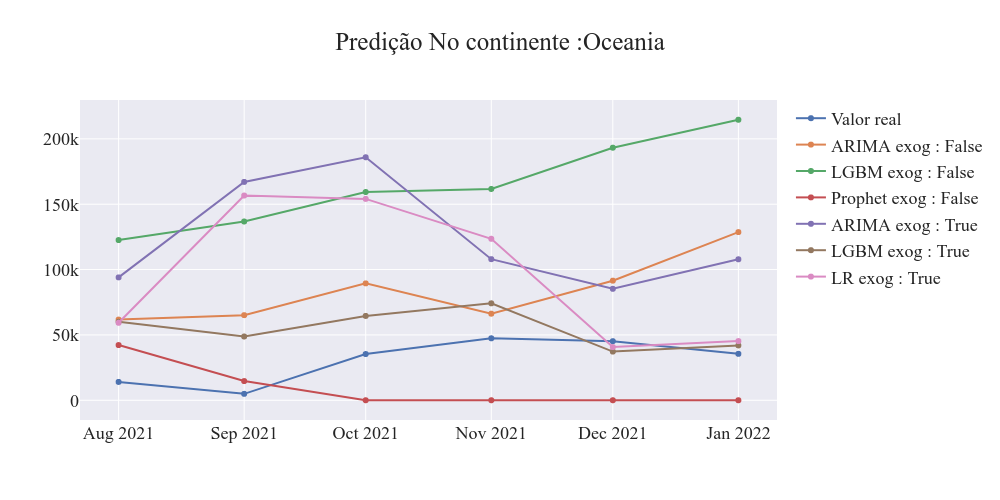

In [70]:
plot_pred_continent(metric_df.loc[metric_df['Continent'] == 'Oceania'], 'Oceania')

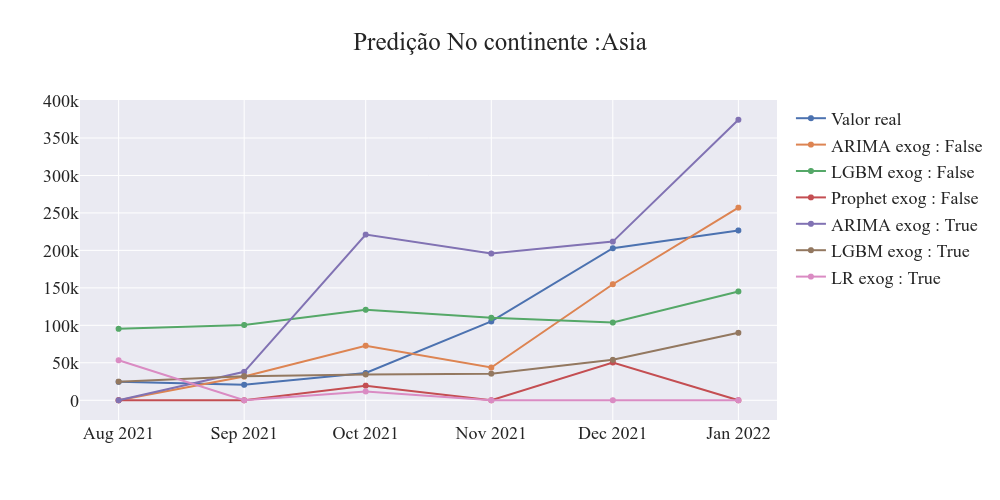

In [71]:
plot_pred_continent(metric_df.loc[metric_df['Continent'] == 'Asia'], 'Asia')

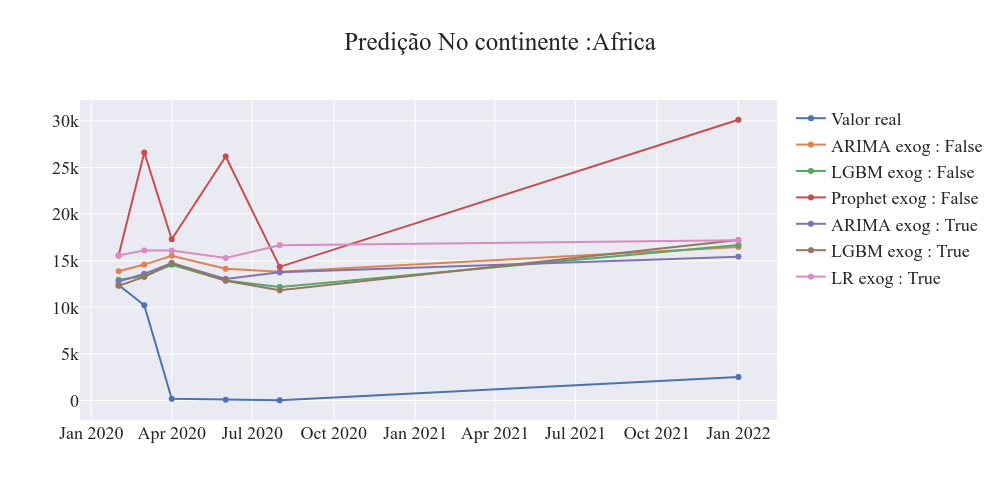

In [72]:
plot_pred_continent(metric_df.loc[metric_df['Continent'] == 'Africa'], 'Africa')

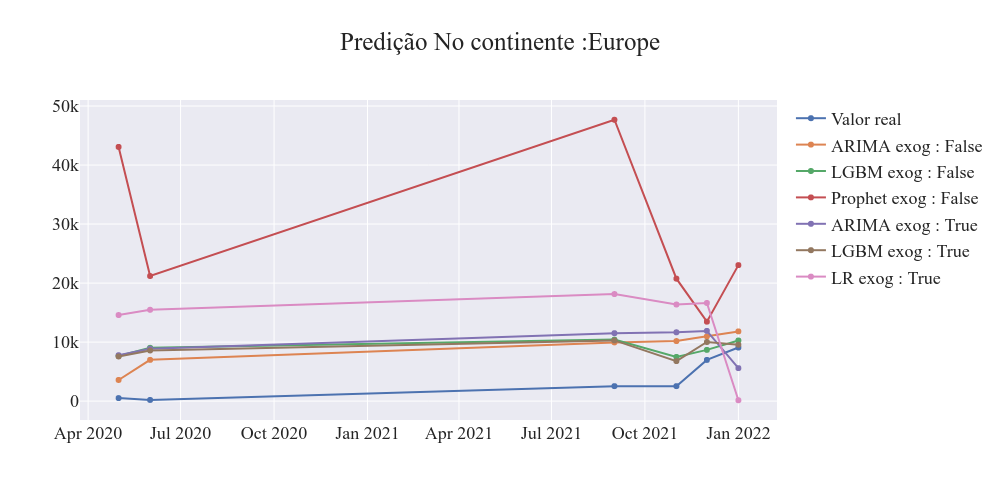

In [73]:
plot_pred_continent(metric_df.loc[metric_df['Continent'] == 'Europe'], 'Europe')

Como é possível observar, para a maioria dos continentes os modelos performaram relativamente bem, considerando uma quebra de regime por conta da pandemia. Porém para o continente africano e europeu todos os modelos performaram mal.

## Filtrando o melhor modelo
Agora vamos filtrar o melhor modelo para cada continente e plotar sua predição.

In [74]:
best_model_df = metric_df.loc[metric_df['Continent'] == continent_names[0]].sort_values(by='MAE').iloc[:1]
for continent in continent_names[1:]:
    best_df_continent = metric_df.loc[metric_df['Continent'] == continent].sort_values(by='MAE').iloc[:1]
    best_model_df = pd.concat([best_model_df, best_df_continent])


In [75]:
best_model_df

,Model,Continent,Exog,MAE,MAPE,R2,pred,y_true,date,forecaster
1,LGBM,South America,False,940.848056,16.325323,-891.571907,"[2060.0772957358845, 280.2371381033482, 945.41...",144 120.0 145 120.0 146 120.0 147 ...,144 2021-02-01 145 2021-03-01 146 2021-0...,ForecastingGridSearchCV(cv=ExpandingWindowSpli...
22,LGBM,Oceania,True,26691.787409,2.328904,-2.866579,"[60011.20184034951, 48773.60217829744, 64512.1...",151 14015.0 152 4904.0 153 35356.0 1...,151 2021-08-01 152 2021-09-01 153 2021-1...,ForecastingGridSearchCV(cv=ExpandingWindowSpli...
6,ARIMA,North America,False,16483.476705,1.254099,-0.428233,"[0.0, 0.0, 1972.9010434807396, 0.0, 2700.92120...",151 5314.0 152 4610.0 153 4497.0 1...,151 2021-08-01 152 2021-09-01 153 2021-1...,"AutoARIMA(sp=12, suppress_warnings=True)"
9,ARIMA,Asia,False,38489.667480,0.711018,0.756862,"[0.0, 31585.237942561977, 72771.86828480654, 4...",151 24528.0 152 20652.0 153 36382....,151 2021-08-01 152 2021-09-01 153 2021-1...,"AutoARIMA(sp=12, suppress_warnings=True)"
31,LGBM,Africa,True,9490.667801,119.871984,-3.722256,"[12298.382577613227, 13258.531987132352, 14737...",133 12383.0 134 10218.0 135 183.0 1...,133 2020-02-01 134 2020-03-01 135 2020-0...,ForecastingGridSearchCV(cv=ExpandingWindowSpli...
34,LGBM,Europe,True,5157.819933,10.212751,-2.204105,"[7566.351586229855, 8582.152797217079, 10288.4...",136 514.0 137 198.0 138 2539.0 139 ...,136 2020-05-01 137 2020-06-01 138 2021-0...,ForecastingGridSearchCV(cv=ExpandingWindowSpli...


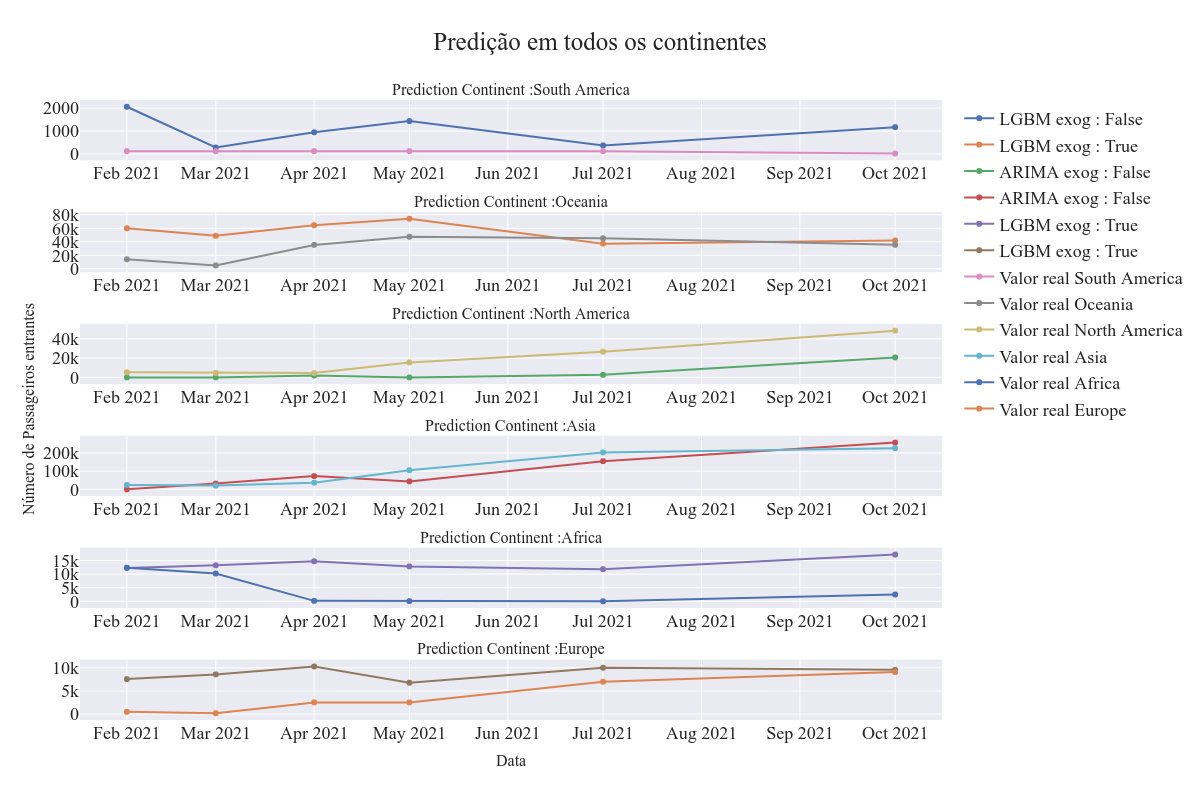

In [76]:
plot_pred_all_continents(best_model_df, continent_names)

## Salvando os melhores modelos
Agora vamos salvar os melhores modelos utilizando o `pickle`

In [77]:
save_dir = 'best_models'
for index, row in best_model_df.iterrows():
    model_name = row['Model']
    model_obj = row['forecaster']
    model_continent = row['Continent']
    model_exog = row['Exog']

    # save
    with open(f'{save_dir}/{model_name}_{model_continent}_exog_{model_exog}.pkl','wb') as f:
        pickle.dump(model_continent,f)

## 6. Conclusões <a name=conc></a>

## Melhor modelo
Como é possível ver na tabela de melhores modelos e no gráfico de previsão os melhores modelos foram o `ARIMA` e o `LGBM regressor`. Sendo que, o modelo ARIMA performou melhor na Asia e na América do norte, nos resto dos continentes (Europa, América do sul, Oceania e Africa) o modelo `LGBM` performou melhor.



## Uso de covariantes
Quanto ao uso ou não de entradas exógenas, podemos afirmar que para o modelo `ARIMA` o uso de entradas exógenas não foi benéfico para o modelo, porém para o modelo `LGBM` na maioria das vezes o uso de entradas exógenas foi benéfico para o modelo.